Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs. After you've installed all the dependencies in the setup.cfg file, let's do some imports to get started.

In [1]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [2]:
# file name and image directory
im_dir = "/srv/shared/SPARE/MC_V_P2_NS_01"
expt_description = 'Network A_SPARE_P2'
filename = 'train_a_SPARE_P2'

We recommend installing the example data at https://ses.library.usyd.edu.au/handle/2123/32282 and adding the unzipped 'data' folder to your present working directory. We'll then define our image directory as 'data/xcat/train' and define a filename to save our weights and loss plots.

Next we'll create a class called 'SupervisedDataset'. This will allow us to load the appropriate data onto the neural network for training. There are a few idiosyncrasies that we may wish to note. First, all the projection data ends in 'bin.npy' because they were originally created as binary files but were converted to .npy files for convience. The same goes for the volumes and DVFs, which end in 'mha.npy' for similar reasons. The source projection has a '06' in front because, in 4D-CTs the 6 respiratory bin corresponds with the peak-exhale phase. We name our projections 'phase_Proj_num', where phase is respiratory phase (i.e. '01', '02', ... '10') and num is the projection number (e.g. '00001'). For Networks D and E, where we train on the CoMBAT MRI data, the naming convention for slice pairs is 'phase_Slice_xc_ys' where x is the slice number along the coronal axis and y is the slice number along the sagittal axis.

An abdominal mask is used later on in the loss function to force the neural network to optimise predictions within a specific region. The data are then reshaped for the specific dimensions expected for a PyTorch neural network. Right now we are also limited to image sizes that are powers of two (e.g. projections 128x128 and volumes 128x128x128). Everything has been downsampled here to fit on the GPU.

In [3]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('subCT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}

        return data

Here is a small visualization of the first 3 projection files within the source subfolder

Lookin' good! Now we will create training and validation datasets

 You can see the difference between the source projection images on both days! As the anatomy may have changed between pre-treatment and intra-treatment days.

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

Are you ready? Next thing to do is to train the network :) We'll save the weights and a plot of the loss curves. We recommend training for 50 epochs. (Using a NVIDIA RTX A6000, this will take 6-8 hours, so we may need to come back tomorrow.)

Let's instantiate the validation dataset class, set up a cuda implementation, and load the pre-trained weights of our network. We'll also print the number of trainable parameters for our records.

In [4]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [ ]:
# =========================
# TRAIN (supports resume)
# =========================

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from continue_training import (
    save_checkpoint,
    load_checkpoint_if_available,
    plot_losses,
)

# ---- device (pick one and keep it consistent) ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- set up network (EXACTLY as before) ----
model = network_a.model(im_size, int_steps=10).to(device)

# ---- loss + optimizer ----
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

print('Training (on ' + str(device) + ')...')
tic = time.time()

# IMPORTANT:
# epoch_num is the TOTAL epoch you want to reach.
# If you trained to 50 and want to continue to 100, set epoch_num = 100.
epoch_num = 20

save_dir = "weights"
plot_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

# ---- resume (loads model+optimizer+history if checkpoint exists) ----
ckpt_path = os.path.join(save_dir, f"{filename}_ckpt.pth")
start_epoch, min_val_loss, train_losses, val_losses = load_checkpoint_if_available(
    ckpt_path=ckpt_path,
    model=model,
    optimizer=optimizer,
    device=device,
)

print(f"Starting at epoch {start_epoch} (target total: {epoch_num})")

# ---- training loop ----
for epoch in range(start_epoch, epoch_num + 1):
    model.train()
    train_loss = 0.0

    for data in trainloader:
        source_proj = data['source_projections'].to(device)
        target_proj = data['target_projections'].to(device)
        source_vol = data['source_volumes'].to(device)
        source_abdomen = data['source_abdomen'].to(device)
        target_flow = data['target_flow'].to(device)

        optimizer.zero_grad(set_to_none=True)
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for valdata in valloader:
            source_proj = valdata['source_projections'].to(device)
            target_proj = valdata['target_projections'].to(device)
            source_vol = valdata['source_volumes'].to(device)
            source_abdomen = valdata['source_abdomen'].to(device)
            target_flow = valdata['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    # ---- metrics ----
    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = int(np.floor(time_elapsed))
    minutes = int((time_elapsed - hours) * 60)

    train_avg = train_loss / len(trainloader)
    val_avg = val_loss / len(valloader)

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_avg, val_avg, hours, minutes))

    train_losses.append(train_avg)
    val_losses.append(val_avg)

    # ---- save best weights (inference) ----
    best_path = os.path.join(save_dir, f"{filename}_best.pth")
    if val_avg < min_val_loss:
        min_val_loss = val_avg
        torch.save(model.state_dict(), best_path)

    # ---- save resume checkpoint (continue training) ----
    save_checkpoint(
        ckpt_path=ckpt_path,
        model=model,
        optimizer=optimizer,
        epoch=epoch,            # last completed epoch
        best_val=min_val_loss,
        train_losses=train_losses,
        val_losses=val_losses,
    )

    # ---- plot ----
    plot_losses(
        plot_dir=plot_dir,
        filename=filename,
        expt_description=expt_description,
        train_losses=train_losses,
        val_losses=val_losses,
        hours=hours,
        minutes=minutes,
    )

print('Finished training')
torch.cuda.empty_cache()

# Show final plot
final_plot = os.path.join(plot_dir, f"{filename}.png")
if os.path.exists(final_plot):
    plt.imshow(plt.imread(final_plot))
    plt.axis("off")
    plt.show()


Training (on cuda:0)...
Starting at epoch 1 (target total: 20)


In [5]:
# file names
expt_file = 'train_a_SPARE_patient2'
test_file = '/srv/shared/SPARE/MC_V_P2_SC_02' # We are using the treatment day dataset with scatter
target_itv_ptv_dir = '/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/Target_ITV_PTVs_All' # PLEASE CHANGE TO YOUR DIR


In [55]:
import os
import numpy as np
import torch
from utilities import spatialTransform


def _ensure_src_ptv_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[None, None, ...]
    elif x.ndim == 5:
        pass
    else:
        raise ValueError(f"Unsupported source PTV shape {x.shape}")
    return x.astype(np.float32)


def _ensure_dvf_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[-1] == 3:
        x = np.transpose(x, (3, 0, 1, 2))[None, ...]
    elif x.ndim == 4 and x.shape[0] == 3:
        x = x[None, ...]
    elif x.ndim == 5 and x.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported DVF shape {x.shape}")
    return x.astype(np.float32)


def generate_target_itv_ptv_10bins(
    im_dir: str,
    out_dir: str,
    im_size: int = 128,
    dvf_folder: str | None = None,
    source_ptv_relpath: str = os.path.join("sub_PTV_mha.npy"),
    dvf_pattern: str = "DVF_{:02d}_mha.npy",
    out_pattern: str = "Target_PTV_{:02d}_mha.npy",
):
    """
    Saves Target ITV PTVs into out_dir.
    """
    if dvf_folder is None:
        dvf_folder = im_dir

    os.makedirs(out_dir, exist_ok=True)

    src_ptv_path = os.path.join(im_dir, source_ptv_relpath)
    if not os.path.exists(src_ptv_path):
        raise FileNotFoundError(f"Missing source ITV PTV: {src_ptv_path}")

    source_ptv_np = _ensure_src_ptv_5d(np.load(src_ptv_path))
    if source_ptv_np.shape[-3:] != (im_size, im_size, im_size):
        raise ValueError(f"Source PTV spatial shape {source_ptv_np.shape[-3:]} != {(im_size,)*3}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device).eval()

    source_ptv_t = torch.from_numpy(source_ptv_np).to(device)

    for b in range(1, 11):
        dvf_path = os.path.join(dvf_folder, dvf_pattern.format(b))
        if not os.path.exists(dvf_path):
            raise FileNotFoundError(f"Missing DVF file: {dvf_path}")

        dvf_np = _ensure_dvf_5d(np.load(dvf_path))
        if dvf_np.shape[-3:] != (im_size, im_size, im_size):
            raise ValueError(f"DVF spatial shape mismatch for {dvf_path}")

        dvf_t = torch.from_numpy(dvf_np).to(device)

        with torch.no_grad():
            tgt_ptv_t = transformer(source_ptv_t, dvf_t)

        tgt_ptv_np = tgt_ptv_t.detach().cpu().numpy()  # [1,1,D,H,W]

        out_path = os.path.join(out_dir, out_pattern.format(b))
        np.save(out_path, tgt_ptv_np)
        print(f"Saved {out_path}")

    print("Done. Target ITV PTVs saved.")

# Save into MC_V_P1_SC_02/Target_ITV/
generate_target_itv_ptv_10bins(
    im_dir="/srv/shared/SPARE/MC_V_P2_SC_02",
    out_dir="/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV",
    im_size=128,
)


Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_01_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_02_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_03_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_04_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_05_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_06_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_07_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_08_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_09_mha.npy
Saved /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_10_mha.npy
Done. Target ITV PTVs saved.


Lets visualize this created target_ITV_PTV

PTV shape: (128, 128, 128)
Unique values (approx): [0.0000000e+00 4.4581026e-05 1.0667859e-04 2.2544760e-04 3.1016947e-04]


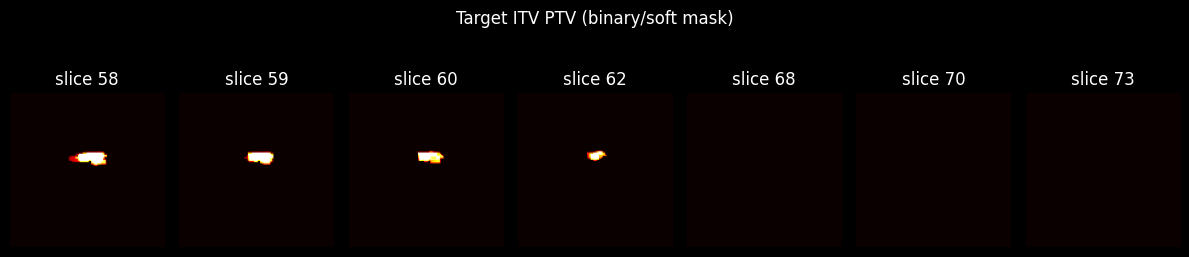

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load PTV volume
ptv_path = "/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV/Target_PTV_01_mha.npy"
ptv = np.squeeze(np.load(ptv_path))  # shape should be (128,128,128)

print("PTV shape:", ptv.shape)
print("Unique values (approx):", np.unique(ptv)[:5])

# Choose a slice axis (change axis if needed: 0, 1, or 2)
axis = 2
ptv_slices = np.moveaxis(ptv, axis, 0)

# Show 5 evenly spaced slices
idxs = [58, 59, 60, 62, 68,70,73]

plt.figure(figsize=(12, 3))
for i, idx in enumerate(idxs):
    plt.subplot(1, 7, i+1)
    plt.imshow(ptv_slices[idx], cmap="hot")
    plt.title(f"slice {idx}")
    plt.axis("off")

plt.suptitle("Target ITV PTV (binary/soft mask)")
plt.tight_layout()
plt.show()


In [57]:
import os
import shutil
import csv

# Paths
target_itv_dir = "/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/TargetPTV"
respbin_csv = "/srv/shared/SPARE/MC_V_P2_SC_02/RespBin.csv"
output_dir = "/home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/Target_ITV_PTVs_All"

os.makedirs(output_dir, exist_ok=True)

targets_created = 0

# Read CSV for mapping
with open(respbin_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)

    for target_idx, row in enumerate(reader, start=1):

        # Skip empty rows
        if not row:
            continue

        # Single column = breathing phase
        breathing_phase = int(row[0])
        if not (1 <= breathing_phase <= 10):
            raise ValueError(
                f"Invalid breathing phase {breathing_phase} at target {target_idx}"
            )

        phase_str = f"{breathing_phase:02d}"

        src_itv = os.path.join(
            target_itv_dir,
            f"Target_PTV_{phase_str}_mha.npy"
        )

        if not os.path.exists(src_itv):
            raise FileNotFoundError(f"Missing ITV file: {src_itv}")

        dst_itv = os.path.join(
            output_dir,
            f"Target_{target_idx:05d}_ITV_PTV.npy"
        )

        shutil.copy(src_itv, dst_itv)
        targets_created += 1

        if targets_created % 50 == 0:
            print(f"Processed {targets_created} targets...")

print(f"\n Successfully created {targets_created} Target ITV PTVs")
print(f" Output directory: {output_dir}")


Processed 50 targets...
Processed 100 targets...
Processed 150 targets...
Processed 200 targets...
Processed 250 targets...
Processed 300 targets...
Processed 350 targets...
Processed 400 targets...
Processed 450 targets...
Processed 500 targets...
Processed 550 targets...
Processed 600 targets...
Processed 650 targets...

 Successfully created 680 Target ITV PTVs
 Output directory: /home/saatwik/Desktop/voxelmap/Voxelmap-main/patient2/Target_ITV_PTVs_All


In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from utilities.helpers import centroid_shift_mm

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder Within the Treatment Day Dataset
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        #source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        source_ptv = np.load(os.path.join(self.im_dir, 'sub_PTV_mha.npy'))

        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]


        vol_name = os.path.join(target_itv_ptv_dir, format('Target_' + target_num + '_ITV_PTV.npy'))
        target_ptv = np.load(vol_name)

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        # ----------------------------
        # DEBUG: Step 3 sanity print
        # ----------------------------
        # if idx < 10:
        #     target_id = target_file.split('_')[1]  # '00001' for Proj_00001_bin.npy
        #     ptv_sum = float(np.sum(target_ptv))
        #     ptv_nz = int(np.count_nonzero(target_ptv))
        #
        #     print(
        #         f"[DBG idx={idx}] target_file={target_file} | "
        #         f"angle={angle:.2f} | RespBin={bin_val} -> subCT_{vol_num}_mha.npy | "
        #         f"target_ptv=Target_{target_id}_ITV_PTV.npy | "
        #         f"ptv_nz={ptv_nz} ptv_sum={ptv_sum:.1f}"
        #     )

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            #'source_lung': to_tensor(source_lung),
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle,
            'target_ptv' :to_tensor(target_ptv)
        }

        return data

In [8]:
# Generate test loader
batch_size = 1
im_size = 128

dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = '/home/saatwik/Desktop/voxelmap/Voxelmap-main/weights/train_a_SPARE_P2_best.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of paramters: 10836973


In [9]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

In [15]:
centroid = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Tracking metrics
tar_lr, tar_si, tar_ap = [], [], []
pred_lr, pred_si, pred_ap = [], [], []
test_angles = []

# Regularity / overlap
test_dice = []
test_detJ = []

# Image quality (template style)
test_mse, test_ssim, test_psnr = [], [], []

print("Testing...")

for i, data in enumerate(testloader, 0):

    # ----------------------------
    # Load inputs (same set as your dataset provides)
    # ----------------------------
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    target_vol  = data['target_volumes'].to(device)
    source_ptv  = data['source_ptv'].to(device)
    target_ptv  = data['target_ptv'].to(device)
    angle       = data['angle'].to(device)

    # ----------------------------
    # Predict DVF
    # ----------------------------
    _, pred_flow = model.forward(source_proj, target_proj, source_vol)

    # ----------------------------
    # Warp source PTV using predicted DVF
    # ----------------------------
    pred_ptv = transformer.forward(source_ptv, pred_flow)

    # ----------------------------
    # Predicted motion (centroid shift)
    # ----------------------------
    pred_lr_mm, pred_si_mm, pred_ap_mm = centroid_shift_mm(
        centroid, source_ptv, pred_ptv
    )

    pred_lr.append(pred_lr_mm)
    pred_si.append(pred_si_mm)
    pred_ap.append(pred_ap_mm)

    # ----------------------------
    # Ground-truth motion (GT DVF-warped PTV)
    # ----------------------------
    gt_lr_mm, gt_si_mm, gt_ap_mm = centroid_shift_mm(
        centroid, source_ptv, target_ptv
    )

    tar_lr.append(gt_lr_mm)
    tar_si.append(gt_si_mm)
    tar_ap.append(gt_ap_mm)

    # ----------------------------
    # Dice similarity (TEMPLATE)
    # ----------------------------
    dice_sim = dice.loss(target_ptv, pred_ptv)
    test_dice.append(float(dice_sim.item()))

    # ----------------------------
    # Jacobian violation ratio (TEMPLATE)
    # ----------------------------
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(pred_flow.detach().cpu().numpy())  # (3, D, H, W)
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]

    detJ = jacobian_determinant.loss(disp)
    detJ_ratio = sum(j <= 0 for j in detJ.flatten()) / detJ.size
    test_detJ.append(float(detJ_ratio))

    # ----------------------------
    # Save gantry angle (TEMPLATE)
    # ----------------------------
    test_angles.append(float(angle.item()))

    # ----------------------------
    # Image Quality metrics (TEMPLATE: flatten + SSIM/PSNR on 1D vectors)
    # ----------------------------
    predict_vol = transformer.forward(source_vol, pred_flow)

    metric_input = target_vol.detach().cpu().numpy().flatten()
    metric_pred  = predict_vol.detach().cpu().numpy().flatten()

    mse_val  = np.sqrt(np.mean(np.square(metric_input - metric_pred)))
    ssim_val = ssim(metric_input, metric_pred,
                    data_range=(np.max(metric_pred) - np.min(metric_pred) + 1e-8))
    psnr_val = psnr(metric_input, metric_pred)

    test_mse.append(float(mse_val))
    test_ssim.append(float(ssim_val))
    test_psnr.append(float(psnr_val))

     # ----------------------------
    # Debug (first few)
    # ----------------------------
    if i < 5:
        print(f"[DBG idx={i}] angle={angle.item():.2f}")
        print("[DBG pred mm lr,si,ap]", pred_lr_mm, pred_si_mm, pred_ap_mm)
        print("[DBG gt   mm lr,si,ap]", gt_lr_mm,  gt_si_mm,  gt_ap_mm)


    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")


Testing...
[DBG idx=0] angle=0.00
[DBG pred mm lr,si,ap] -1.9511260986328125 5.272007751464844 1.737997055053711
[DBG gt   mm lr,si,ap] -1.8353824615478516 5.238921356201172 2.2446842193603516
0 of 680
[DBG idx=1] angle=0.53
[DBG pred mm lr,si,ap] -1.9692306518554688 4.958692169189453 1.7967033386230469
[DBG gt   mm lr,si,ap] -1.8353824615478516 5.238921356201172 2.2446842193603516
[DBG idx=2] angle=1.06
[DBG pred mm lr,si,ap] -1.8938751220703125 4.724791717529297 1.0392894744873047
[DBG gt   mm lr,si,ap] 0.5060997009277344 3.9999908447265624 1.2902164459228516
[DBG idx=3] angle=1.59
[DBG pred mm lr,si,ap] -1.8883075714111328 4.730394744873046 1.0278739929199219
[DBG gt   mm lr,si,ap] 0.5060997009277344 3.9999908447265624 1.2902164459228516
[DBG idx=4] angle=2.12
[DBG pred mm lr,si,ap] -1.8971595764160156 4.724687957763671 1.0743236541748047
[DBG gt   mm lr,si,ap] 0.5060997009277344 3.9999908447265624 1.2902164459228516
10 of 680


KeyboardInterrupt: 

In [12]:
print("\n===== TEST SUMMARY =====")

# Convert to numpy
tar_lr_np  = np.asarray(tar_lr, dtype=float)
tar_si_np  = np.asarray(tar_si, dtype=float)
tar_ap_np  = np.asarray(tar_ap, dtype=float)

pred_lr_np = np.asarray(pred_lr, dtype=float)
pred_si_np = np.asarray(pred_si, dtype=float)
pred_ap_np = np.asarray(pred_ap, dtype=float)

test_dice_np = np.asarray(test_dice, dtype=float)
test_detJ_np = np.asarray(test_detJ, dtype=float)

test_mse_np  = np.asarray(test_mse, dtype=float)
test_ssim_np = np.asarray(test_ssim, dtype=float)
test_psnr_np = np.asarray(test_psnr, dtype=float)

# ----------------------------
# Motion error (centroid-based)
# ----------------------------
err_3d = np.sqrt(
    (tar_lr_np - pred_lr_np) ** 2 +
    (tar_si_np - pred_si_np) ** 2 +
    (tar_ap_np - pred_ap_np) ** 2
)

print("\n--- Motion Tracking (Centroid) ---")
print(f"3D Error (mm):   {np.mean(err_3d):.2f} ± {np.std(err_3d):.2f}")

print("Axis-wise absolute error (mm):")
print(f"  LR: {np.mean(np.abs(tar_lr_np - pred_lr_np)):.2f} ± {np.std(np.abs(tar_lr_np - pred_lr_np)):.2f}")
print(f"  SI: {np.mean(np.abs(tar_si_np - pred_si_np)):.2f} ± {np.std(np.abs(tar_si_np - pred_si_np)):.2f}")
print(f"  AP: {np.mean(np.abs(tar_ap_np - pred_ap_np)):.2f} ± {np.std(np.abs(tar_ap_np - pred_ap_np)):.2f}")

# ----------------------------
# PTV overlap
# ----------------------------
print("\n--- PTV Overlap ---")
print(f"Dice:            {np.mean(test_dice_np):.3f} ± {np.std(test_dice_np):.3f}")

# ----------------------------
# DVF regularity
# ----------------------------
print("\n--- DVF Regularity ---")
print(f"detJ ≤ 0 ratio:  {np.mean(test_detJ_np):.2e} ± {np.std(test_detJ_np):.2e}")

# ----------------------------
# Image similarity (warped volume)
# ----------------------------
print("\n--- Image Similarity (Warped Source → Target) ---")
print(f"MSE:             {np.mean(test_mse_np):.4e} ± {np.std(test_mse_np):.4e}")
print(f"SSIM:            {np.mean(test_ssim_np):.4f} ± {np.std(test_ssim_np):.4f}")
print(f"PSNR (dB):       {np.mean(test_psnr_np):.2f} ± {np.std(test_psnr_np):.2f}")



===== TEST SUMMARY =====

--- Motion Tracking (Centroid) ---
3D Error (mm):   1.82 ± 0.90
Axis-wise absolute error (mm):
  LR: 0.61 ± 0.86
  SI: 0.97 ± 0.73
  AP: 0.99 ± 0.74

--- PTV Overlap ---
Dice:            0.927 ± 0.022

--- DVF Regularity ---
detJ ≤ 0 ratio:  0.00e+00 ± 0.00e+00

--- Image Similarity (Warped Source → Target) ---
MSE:             8.4970e-04 ± 3.2219e-04
SSIM:            0.9366 ± 0.0276
PSNR (dB):       62.22 ± 4.07


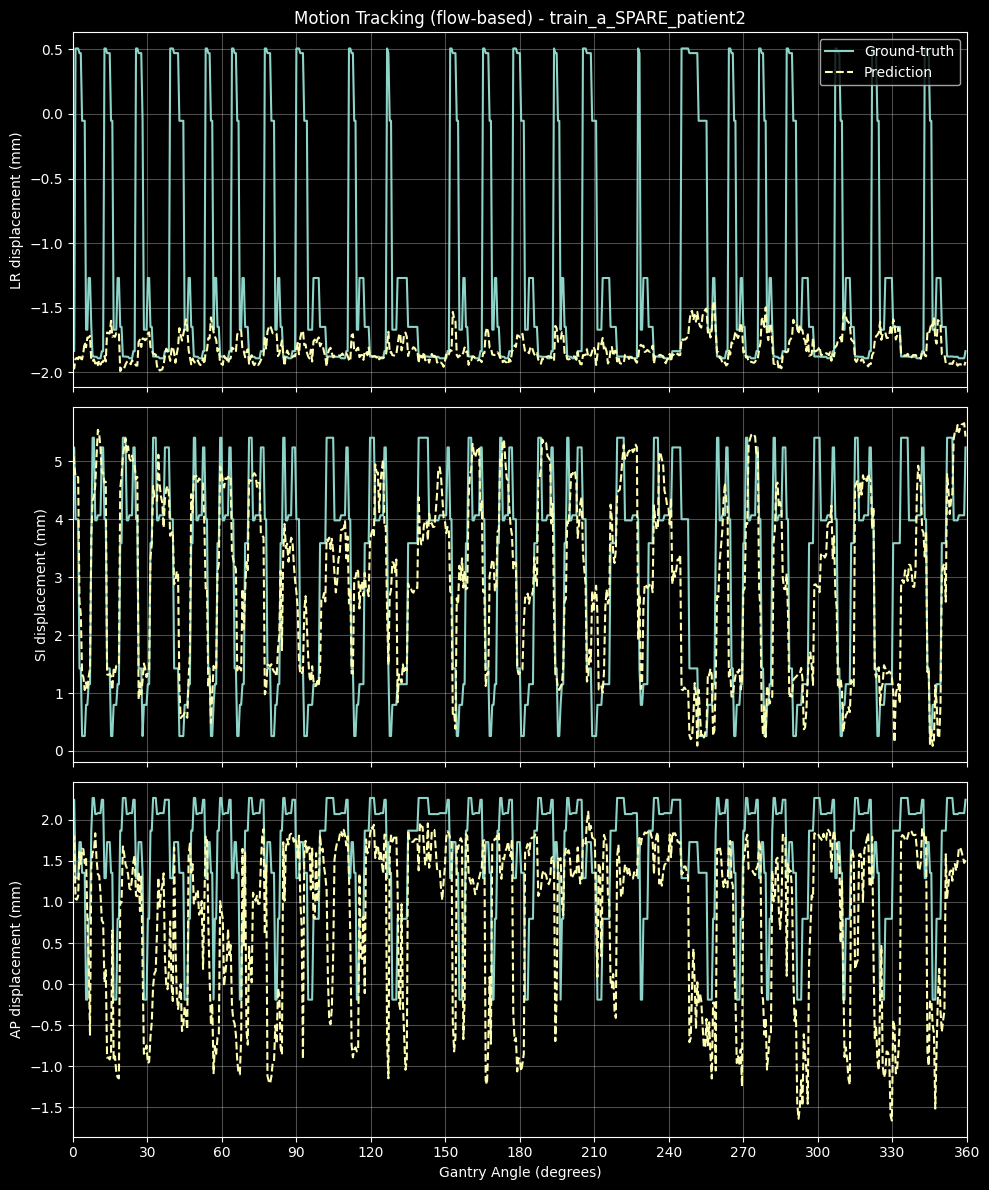

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt


# Create experiment directory
plot_dir = os.path.join("plots", expt_file)
os.makedirs(plot_dir, exist_ok=True)

# Save arrays (optional but consistent with your pipeline)
np.save(os.path.join(plot_dir, "test_angles.npy"), np.asarray(test_angles, dtype=float))
np.save(os.path.join(plot_dir, "tar_lr_mm.npy"), np.asarray(tar_lr, dtype=float))
np.save(os.path.join(plot_dir, "tar_si_mm.npy"), np.asarray(tar_si, dtype=float))
np.save(os.path.join(plot_dir, "tar_ap_mm.npy"), np.asarray(tar_ap, dtype=float))
np.save(os.path.join(plot_dir, "pred_lr_mm.npy"), np.asarray(pred_lr, dtype=float))
np.save(os.path.join(plot_dir, "pred_si_mm.npy"), np.asarray(pred_si, dtype=float))
np.save(os.path.join(plot_dir, "pred_ap_mm.npy"), np.asarray(pred_ap, dtype=float))

# Helper: sort a trace by angle (no mean-centering; these are displacements)
def sort_by_angle(trace, angles):
    trace = np.asarray(trace, dtype=float)
    angles = np.asarray(angles, dtype=float)
    order = np.argsort(angles)
    return angles[order], trace[order]

# Get sorted x-axis (angles) + traces
sorted_angles, tar_lr_plot  = sort_by_angle(tar_lr,  test_angles)
_,            tar_si_plot  = sort_by_angle(tar_si,  test_angles)
_,            tar_ap_plot  = sort_by_angle(tar_ap,  test_angles)

_,            pred_lr_plot = sort_by_angle(pred_lr, test_angles)
_,            pred_si_plot = sort_by_angle(pred_si, test_angles)
_,            pred_ap_plot = sort_by_angle(pred_ap, test_angles)

# Plotting
f, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

labels = ["LR displacement (mm)", "SI displacement (mm)", "AP displacement (mm)"]
tar_data  = [tar_lr_plot,  tar_si_plot,  tar_ap_plot]
pred_data = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.plot(sorted_angles, tar_data[idx],  label="Ground-truth")
    ax.plot(sorted_angles, pred_data[idx], label="Prediction", linestyle="--")
    ax.set_ylabel(labels[idx])

    # Angle axis settings
    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))

    # Let y-limits autoscale (usually best while debugging)
    # If you prefer fixed bounds, uncomment:
    # ax.set_ylim([-10, 10])

    ax.grid(True, alpha=0.3)

    if idx == 0:
        ax.set_title(f"Motion Tracking (flow-based) - {expt_file}")
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Gantry Angle (degrees)")

f.tight_layout()
out_path = os.path.join(plot_dir, f"{expt_file}_trace.png")
plt.savefig(out_path, dpi=200)
plt.show()
